### RUNS ON GRID

### Example 04. Image classification using hybrid datasets (original and synthetic datasets)

This example notebook is intended to serve as a guide for csl data synthesis module and its associated methods.

**CSL Modules:**
* `dataloaders`: hybrid dataloaders

* `datasets`: differentially private datasets in ImageFolder structure

---

**This notebook:** 

Focuses on the `dataloaders` module and its associated processes and modules, which include:

A. (previously created) Differentially private datasets using `ALPHA` ($\alpha$) and `EPSILON` ($\epsilon$) for imnmediate sensitivity
* See `csl/datasets.py` to add a new ImageFolder-structured dataset
* Ensure that the new dataset lives in the path defined by `DATA_DIR` defined in `csl/datasets.py` (approx ln number 57)


### COMMON ERRORS

1. `Dataset '{DATASET_NAME}' -- not implemented. It can be added if ImageFolder structure is followed.`

**Solution**
      
  a. add the entry to the top of the `csl/datasets.py` file
    
  b. ensure the file is in ImageFolder structure and that the dataset lives under `/persist/datasets/`


In [1]:
import math
import logging
import coloredlogs
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torchvision

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

import sys
sys.path.append("/persist/carlos_folder/csl/csl")

import os
os.chdir("../")

# import csl.synthesizers as syn
import csl.utils.utils as cutils
import csl.datasets as dsets

In [2]:
DEVICE = "cuda:0"
torch.manual_seed(1)
torch.cuda.set_device(0)
torch.multiprocessing.set_sharing_strategy('file_system')

In [3]:
# DATASET INFO
DATASET_NAME = "fashion-mnist"
# SYN_NAME = "vae"
# SYN_NAME = "dcgan"
SYN_NAME = "dcgan_dp_20a_1000000.0e"
# SYN_NAME = "dcgan_dp_20a_200000.0e"
# SYN_NAME = "mnist_dcgan_dp_20a_100000.0e"
SYNTHETIC_DATASET_NAME = f"{DATASET_NAME}_{SYN_NAME}"

# RUN_HYBRID_EVALUATION = True

# image dimensions & grayscale vs. rgb images
N_CHANNELS = 1 if "mnist" in DATASET_NAME else 3
INPUT_SIZE = 28

# TRAINING/TESTING INFO
NUM_WORKERS = 16
BATCH_SIZE = 16
N_EPOCHS = 25
N_RUNS = 10

# LR = 0.001  # Ben suggestion
LR = 2e-4 if DATASET_NAME == "cifar10" else 0.001


In [4]:
# log = logging.getLogger("03_hybrid_cifar10-cvae")
# confirm the results directories: plots and logs
cutils.confirm_directory(f"plots/{SYNTHETIC_DATASET_NAME}/")
cutils.confirm_directory(f"logs/{SYNTHETIC_DATASET_NAME}/")

log = logging.getLogger("04_mnist")
coloredlogs.install(level="info", logger=log)


# RUN HYBRID DATA EVALUATION
LOG_FILE = f"logs/{SYNTHETIC_DATASET_NAME}/04_log_hybrid_classifiers.txt"
logging.basicConfig(
    filename=f"{LOG_FILE}",
    level=logging.DEBUG,
)

2021-01-31 20:43:06 53447080b262 utils[351968] INFO The directory 'plots/fashion-mnist_dcgan_dp_20a_1000000.0e/' exists. Ready to use.
2021-01-31 20:43:06 53447080b262 utils[351968] INFO The directory 'logs/fashion-mnist_dcgan_dp_20a_1000000.0e/' exists. Ready to use.


### THE GELMAN-NET IMAGE CLASSIFIER

In [5]:
class gelman_Classifier(nn.Module):
    def __init__(self):
        super(gelman_Classifier, self).__init__()
        self.conv1 = nn.Conv2d(N_CHANNELS, INPUT_SIZE, kernel_size=(5, 5))
        self.conv2 = nn.Conv2d(INPUT_SIZE, 32, kernel_size=(5, 5))
        self.fc1 = nn.Linear(32*20*20, 16)
        self.fc2 = nn.Linear(16, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.ReLU()(x)
        x = self.conv2(x)
        x = nn.ReLU()(x)
        # print(x.size()) --> torch.Size([16, 32, 20, 20])
        x = x.view(-1, 32*20*20)
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.fc2(x)
        x = nn.ReLU()(x)
        return torch.softmax(x, dim=1)


def init_xavier(m):
    """ xavier weight initialization
    """
    if type(m) == nn.Linear:
        nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

def init_kaiming(m):
    """kaiming weight initialization
    """
    if type(m) == nn.Linear:
        weights, bias = m.named_parameters()
        m.weight = torch.nn.Parameter(
            torch.randn(
                weights[1].shape[0],
                weights[1].shape[1]
            ) * math.sqrt(2./weights[1].shape[0])
        )
        m.bias.data.fill_(0)

def one_hot_label(label, num_classes: int = 10) -> torch.Tensor:
    """Helper. One-hot-encode labels"""
    zeros = [0.0]*num_classes
    zeros[label] = 1.0
    return torch.tensor(zeros)

def classifier_accuracy(model, test_loader):
    correct = 0
    num_data = 0
    # grab a batch from the test loader
    for examples, labels in test_loader:
        outputs = model.forward(examples.to(DEVICE))
        # for each output in the batch, check if the label is correct
        for i, output in enumerate(outputs):
            num_data += 1
            max_i = np.argmax(output.cpu().detach().numpy())
            if max_i == labels[i]:
                correct += 1
    acc = float(correct)/num_data
    return acc


def visualize_batch_data(data_loader, class_idx: int = "all", img_tag: str = None):
    # step 5. Display all batches using a grid
    for b, (batch, labels) in enumerate(data_loader):
        plot_title = f"{b}-th batch from {DATASET_NAME} dataset ({class_idx}-class)"
        if img_tag is not None:
            plot_title = f"{b}-th batch from {DATASET_NAME} dataset "
            f"({class_idx}-class; {img_tag})"
        cutils.visualize_batch(batch, plot_title=plot_title, grid_dims=8)


### TRAIN AND TEST ROUTINES

In [6]:
def train_and_test_clf(train_load, test_loader):
    # reset the model
    model = gelman_Classifier()
    model.apply(init_kaiming)  # init_xavier,
    model_optimizer = optim.Adam(model.parameters(), lr=LR)
    model.to(DEVICE)

    criterion = nn.CrossEntropyLoss()

    model.train()
    for epoch in range(N_EPOCHS):
        log.info(
            f"  >> [NEXT] \nStart of epoch {epoch} using "
            f"({original_portion * 100})% original and "
            f"({synthetic_portion * 100})% synthetic."
        )
        # for batch_id, (x_batch_train, labels) in enumerate(train_loader):
        for batch_id, (x_batch_train, labels) in zip(
            tqdm(range(len(train_loader)), desc=f"Train {run}-run batch {epoch}"),
            train_loader
        ):
            # zero out the gradients from the previous iteration
            model_optimizer.zero_grad()

            inp = Variable(
                x_batch_train.to(DEVICE),
                requires_grad=True
            )
            outputs = model.forward(inp)
            loss = criterion(outputs, labels.to(DEVICE))
            loss.backward()
            train_losses.append(loss.item())

            # perform the backpropagation
            model_optimizer.step()

        # accuracy and loss
        train_hist.append(np.array(train_losses).mean())
        log.info(f" >>> Average train loss: {train_hist[-1]: .5f}")

        model.eval()
        with torch.no_grad():
            acc_val = classifier_accuracy(model.eval(), test_loader)
            test_accs[run, epoch] = acc_val
        log.info(f" >>> Test Accuracy: {acc_val: .5f}")

        log.info("DONE TRAINING AND TESTING THE CURRENT HYBRID SETUP -- PLOT!")
        # # ---
        # The metrics & for the specific hybrid ratio/combination
        # plot (mean and std)
        # # ---
        ave_test_accs.append(test_accs.mean(axis=0))
        std_test_accs.append(test_accs.std(axis=0))
        plot_labels.append(
            f"{int(synthetic_portion * 100)}%-SYN "
            f"({ave_test_accs[-1][-1] * 100:.1f}% acc "
            f"std={ave_test_accs[-1][-1]:.2f})"
        )

## MAIN LOOP -- STEPS:
1. set experiment parameters (`hybrid_kwargs`)
2. set data original and synthetic data `portions` (floats)
3. repeat each configuration `N_RUNS`-times for each of the `portion` configurations
4. set a new shuffling seed for data from each source (original and syhtetic)
5. produce plot results for (a) each configuration and for (b) the complete dataset (see `plots/{SYNTHETIC_DATASET_NAME}/` directory) logs of the experiment can be found under the `logs/` directory.

In [7]:
# step 1:
hybrid_kwargs = {
    "dataset_name": DATASET_NAME,
    "image_size": INPUT_SIZE,
    "method": SYN_NAME,
    "batch_size": BATCH_SIZE,
    # original_portion
    # synthetic_portion
    "num_workers": NUM_WORKERS,
}

# step 2:
portions = [
    # hybrids
    (0.5, 0.5),
    (0.1, 0.9),
    (0.01, 0.99),
    # synthetic only
    (0.0, 1.0),
    # original dataset
    (1.0, 0.0),
    (0.5, 0.0),
    (0.1, 0.0), 
]

2021-01-31 20:43:06 53447080b262 04_mnist[351968] INFO ====
[RUN] starting run: 0
 ====
2021-01-31 20:43:06 53447080b262 csl.datasets[351968] INFO Processing 'fashion-mnist' torch.vision built-in structure
2021-01-31 20:43:06 53447080b262 csl.datasets[351968] INFO Loaded complete original 'fashion-mnist' dataset with 60000 training data and 10000 test data.
2021-01-31 20:43:06 53447080b262 csl.datasets[351968] INFO  > Splitted original 'fashion-mnist' dataset with 30000 training data and 10000 test data.
2021-01-31 20:43:06 53447080b262 csl.datasets[351968] INFO Processing 'fashion-mnist_dcgan_dp_20a_1000000.0e' ImageFolder structure
2021-01-31 20:43:07 53447080b262 csl.datasets[351968] INFO  Loaded complete synthetic 'fashion-mnist_dcgan_dp_20a_1000000.0e'  dataset with 60000 training data and 10000 test data.
2021-01-31 20:43:07 53447080b262 csl.datasets[351968] INFO  > Splitted synthetic 'fashion-mnist_dcgan_dp_20a_1000000.0e' dataset with 30000 training data and 10000 test data.
20

2021-01-31 20:48:51 53447080b262 04_mnist[351968] INFO   >> [NEXT] 
Start of epoch 18 using (50.0)% original and (50.0)% synthetic.
Train 0-run batch 18: 100%|██████████| 3750/3750 [00:15<00:00, 236.57it/s]
2021-01-31 20:49:07 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.62969
2021-01-31 20:49:11 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  0.77640
2021-01-31 20:49:11 53447080b262 04_mnist[351968] INFO   >> [NEXT] 
Start of epoch 19 using (50.0)% original and (50.0)% synthetic.
Train 0-run batch 19: 100%|██████████| 3750/3750 [00:15<00:00, 239.58it/s]
2021-01-31 20:49:26 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.62875
2021-01-31 20:49:29 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  0.76650
2021-01-31 20:49:29 53447080b262 04_mnist[351968] INFO   >> [NEXT] 
Start of epoch 20 using (50.0)% original and (50.0)% synthetic.
Train 0-run batch 20: 100%|██████████| 3750/3750 [00:15<00:00, 240.38it/s]
2021-01-31 20:49:45 53447080b262 

Train 1-run batch 11: 100%|██████████| 3750/3750 [00:15<00:00, 236.50it/s]
2021-01-31 20:54:48 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.60216
2021-01-31 20:54:52 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  0.86730
2021-01-31 20:54:52 53447080b262 04_mnist[351968] INFO   >> [NEXT] 
Start of epoch 12 using (50.0)% original and (50.0)% synthetic.
Train 1-run batch 12: 100%|██████████| 3750/3750 [00:15<00:00, 236.97it/s]
2021-01-31 20:55:07 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.60020
2021-01-31 20:55:11 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  0.85890
2021-01-31 20:55:11 53447080b262 04_mnist[351968] INFO   >> [NEXT] 
Start of epoch 13 using (50.0)% original and (50.0)% synthetic.
Train 1-run batch 13: 100%|██████████| 3750/3750 [00:16<00:00, 234.23it/s]
2021-01-31 20:55:27 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.59827
2021-01-31 20:55:29 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  

Train 2-run batch 4: 100%|██████████| 3750/3750 [00:15<00:00, 246.33it/s]
2021-01-31 21:00:29 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.58692
2021-01-31 21:00:32 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  0.81670
2021-01-31 21:00:32 53447080b262 04_mnist[351968] INFO   >> [NEXT] 
Start of epoch 5 using (50.0)% original and (50.0)% synthetic.
Train 2-run batch 5: 100%|██████████| 3750/3750 [00:15<00:00, 235.57it/s]
2021-01-31 21:00:48 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.58721
2021-01-31 21:00:51 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  0.81840
2021-01-31 21:00:51 53447080b262 04_mnist[351968] INFO   >> [NEXT] 
Start of epoch 6 using (50.0)% original and (50.0)% synthetic.
Train 2-run batch 6: 100%|██████████| 3750/3750 [00:15<00:00, 240.77it/s]
2021-01-31 21:01:07 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.58746
2021-01-31 21:01:10 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  0.817

2021-01-31 21:06:49 53447080b262 csl.datasets[351968] INFO  > Splitted original 'fashion-mnist' dataset with 30000 training data and 10000 test data.
2021-01-31 21:06:49 53447080b262 csl.datasets[351968] INFO Processing 'fashion-mnist_dcgan_dp_20a_1000000.0e' ImageFolder structure
2021-01-31 21:06:49 53447080b262 csl.datasets[351968] INFO  Loaded complete synthetic 'fashion-mnist_dcgan_dp_20a_1000000.0e'  dataset with 60000 training data and 10000 test data.
2021-01-31 21:06:49 53447080b262 csl.datasets[351968] INFO  > Splitted synthetic 'fashion-mnist_dcgan_dp_20a_1000000.0e' dataset with 30000 training data and 10000 test data.
2021-01-31 21:06:49 53447080b262 csl.datasets[351968] INFO Constructed a hybrid 'fashion-mnist_dcgan_dp_20a_1000000.0e' dataset with 0.50-original and 0.50-hybrid portions to produce 60000 training and 10000 test datasets.
2021-01-31 21:06:49 53447080b262 04_mnist[351968] INFO   >> [NEXT] 
Start of epoch 0 using (50.0)% original and (50.0)% synthetic.
Train 3-

Train 3-run batch 19: 100%|██████████| 3750/3750 [00:15<00:00, 236.70it/s]
2021-01-31 21:13:02 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.58661
2021-01-31 21:13:05 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  0.79980
2021-01-31 21:13:05 53447080b262 04_mnist[351968] INFO   >> [NEXT] 
Start of epoch 20 using (50.0)% original and (50.0)% synthetic.
Train 3-run batch 20: 100%|██████████| 3750/3750 [00:16<00:00, 231.06it/s]
2021-01-31 21:13:22 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.58681
2021-01-31 21:13:25 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  0.79630
2021-01-31 21:13:25 53447080b262 04_mnist[351968] INFO   >> [NEXT] 
Start of epoch 21 using (50.0)% original and (50.0)% synthetic.
Train 3-run batch 21: 100%|██████████| 3750/3750 [00:15<00:00, 245.13it/s]
2021-01-31 21:13:40 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.58698
2021-01-31 21:13:43 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  

Train 4-run batch 12: 100%|██████████| 3750/3750 [00:15<00:00, 240.48it/s]
2021-01-31 21:18:43 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.58966
2021-01-31 21:18:46 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  0.86860
2021-01-31 21:18:46 53447080b262 04_mnist[351968] INFO   >> [NEXT] 
Start of epoch 13 using (50.0)% original and (50.0)% synthetic.
Train 4-run batch 13: 100%|██████████| 3750/3750 [00:15<00:00, 247.30it/s]
2021-01-31 21:19:02 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.58906
2021-01-31 21:19:05 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  0.87110
2021-01-31 21:19:05 53447080b262 04_mnist[351968] INFO   >> [NEXT] 
Start of epoch 14 using (50.0)% original and (50.0)% synthetic.
Train 4-run batch 14: 100%|██████████| 3750/3750 [00:15<00:00, 237.76it/s]
2021-01-31 21:19:21 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.58845
2021-01-31 21:19:23 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  

Train 5-run batch 5: 100%|██████████| 3750/3750 [00:15<00:00, 236.73it/s]
2021-01-31 21:24:24 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.59208
2021-01-31 21:24:26 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  0.72410
2021-01-31 21:24:26 53447080b262 04_mnist[351968] INFO   >> [NEXT] 
Start of epoch 6 using (50.0)% original and (50.0)% synthetic.
Train 5-run batch 6: 100%|██████████| 3750/3750 [00:15<00:00, 238.82it/s]
2021-01-31 21:24:42 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.59279
2021-01-31 21:24:45 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  0.72140
2021-01-31 21:24:45 53447080b262 04_mnist[351968] INFO   >> [NEXT] 
Start of epoch 7 using (50.0)% original and (50.0)% synthetic.
Train 5-run batch 7: 100%|██████████| 3750/3750 [00:15<00:00, 237.65it/s]
2021-01-31 21:25:01 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.59345
2021-01-31 21:25:05 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  0.733

2021-01-31 21:30:25 53447080b262 csl.datasets[351968] INFO  Loaded complete synthetic 'fashion-mnist_dcgan_dp_20a_1000000.0e'  dataset with 60000 training data and 10000 test data.
2021-01-31 21:30:25 53447080b262 csl.datasets[351968] INFO  > Splitted synthetic 'fashion-mnist_dcgan_dp_20a_1000000.0e' dataset with 30000 training data and 10000 test data.
2021-01-31 21:30:25 53447080b262 csl.datasets[351968] INFO Constructed a hybrid 'fashion-mnist_dcgan_dp_20a_1000000.0e' dataset with 0.50-original and 0.50-hybrid portions to produce 60000 training and 10000 test datasets.
2021-01-31 21:30:25 53447080b262 04_mnist[351968] INFO   >> [NEXT] 
Start of epoch 0 using (50.0)% original and (50.0)% synthetic.
Train 6-run batch 0: 100%|██████████| 3750/3750 [00:15<00:00, 237.04it/s]
2021-01-31 21:30:41 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.59765
2021-01-31 21:30:44 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  0.69310
2021-01-31 21:30:44 53447080b262 04_mnist[3

Train 6-run batch 20: 100%|██████████| 3750/3750 [00:14<00:00, 250.81it/s]
2021-01-31 21:36:56 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.60401
2021-01-31 21:36:59 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  0.84900
2021-01-31 21:36:59 53447080b262 04_mnist[351968] INFO   >> [NEXT] 
Start of epoch 21 using (50.0)% original and (50.0)% synthetic.
Train 6-run batch 21: 100%|██████████| 3750/3750 [00:15<00:00, 239.48it/s]
2021-01-31 21:37:14 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.60366
2021-01-31 21:37:17 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  0.84590
2021-01-31 21:37:17 53447080b262 04_mnist[351968] INFO   >> [NEXT] 
Start of epoch 22 using (50.0)% original and (50.0)% synthetic.
Train 6-run batch 22: 100%|██████████| 3750/3750 [00:15<00:00, 237.76it/s]
2021-01-31 21:37:33 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.60330
2021-01-31 21:37:36 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  

Train 7-run batch 13: 100%|██████████| 3750/3750 [00:16<00:00, 233.71it/s]
2021-01-31 21:42:37 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.60811
2021-01-31 21:42:40 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  0.80040
2021-01-31 21:42:40 53447080b262 04_mnist[351968] INFO   >> [NEXT] 
Start of epoch 14 using (50.0)% original and (50.0)% synthetic.
Train 7-run batch 14: 100%|██████████| 3750/3750 [00:15<00:00, 240.81it/s]
2021-01-31 21:42:56 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.60810
2021-01-31 21:42:59 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  0.80020
2021-01-31 21:42:59 53447080b262 04_mnist[351968] INFO   >> [NEXT] 
Start of epoch 15 using (50.0)% original and (50.0)% synthetic.
Train 7-run batch 15: 100%|██████████| 3750/3750 [00:15<00:00, 246.46it/s]
2021-01-31 21:43:14 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.60809
2021-01-31 21:43:17 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  

Train 8-run batch 6: 100%|██████████| 3750/3750 [00:15<00:00, 237.67it/s]
2021-01-31 21:48:17 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.61416
2021-01-31 21:48:20 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  0.73150
2021-01-31 21:48:20 53447080b262 04_mnist[351968] INFO   >> [NEXT] 
Start of epoch 7 using (50.0)% original and (50.0)% synthetic.
Train 8-run batch 7: 100%|██████████| 3750/3750 [00:15<00:00, 236.19it/s]
2021-01-31 21:48:36 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.61453
2021-01-31 21:48:39 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  0.74470
2021-01-31 21:48:39 53447080b262 04_mnist[351968] INFO   >> [NEXT] 
Start of epoch 8 using (50.0)% original and (50.0)% synthetic.
Train 8-run batch 8: 100%|██████████| 3750/3750 [00:15<00:00, 240.55it/s]
2021-01-31 21:48:55 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.61462
2021-01-31 21:48:58 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  0.782

2021-01-31 21:54:00 53447080b262 csl.datasets[351968] INFO Constructed a hybrid 'fashion-mnist_dcgan_dp_20a_1000000.0e' dataset with 0.50-original and 0.50-hybrid portions to produce 60000 training and 10000 test datasets.
2021-01-31 21:54:00 53447080b262 04_mnist[351968] INFO   >> [NEXT] 
Start of epoch 0 using (50.0)% original and (50.0)% synthetic.
Train 9-run batch 0: 100%|██████████| 3750/3750 [00:15<00:00, 237.22it/s]
2021-01-31 21:54:16 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.61534
2021-01-31 21:54:19 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  0.63130
2021-01-31 21:54:19 53447080b262 04_mnist[351968] INFO   >> [NEXT] 
Start of epoch 1 using (50.0)% original and (50.0)% synthetic.
Train 9-run batch 1: 100%|██████████| 3750/3750 [00:15<00:00, 237.62it/s]
2021-01-31 21:54:35 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.61587
2021-01-31 21:54:38 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  0.76700
2021-01-31 21:54:38 5

Train 9-run batch 21: 100%|██████████| 3750/3750 [00:15<00:00, 241.40it/s]
2021-01-31 22:00:54 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.61542
2021-01-31 22:00:57 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  0.80360
2021-01-31 22:00:57 53447080b262 04_mnist[351968] INFO   >> [NEXT] 
Start of epoch 22 using (50.0)% original and (50.0)% synthetic.
Train 9-run batch 22: 100%|██████████| 3750/3750 [00:15<00:00, 237.31it/s]
2021-01-31 22:01:13 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.61536
2021-01-31 22:01:16 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  0.80600
2021-01-31 22:01:16 53447080b262 04_mnist[351968] INFO   >> [NEXT] 
Start of epoch 23 using (50.0)% original and (50.0)% synthetic.
Train 9-run batch 23: 100%|██████████| 3750/3750 [00:15<00:00, 238.13it/s]
2021-01-31 22:01:32 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.61530
2021-01-31 22:01:35 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  

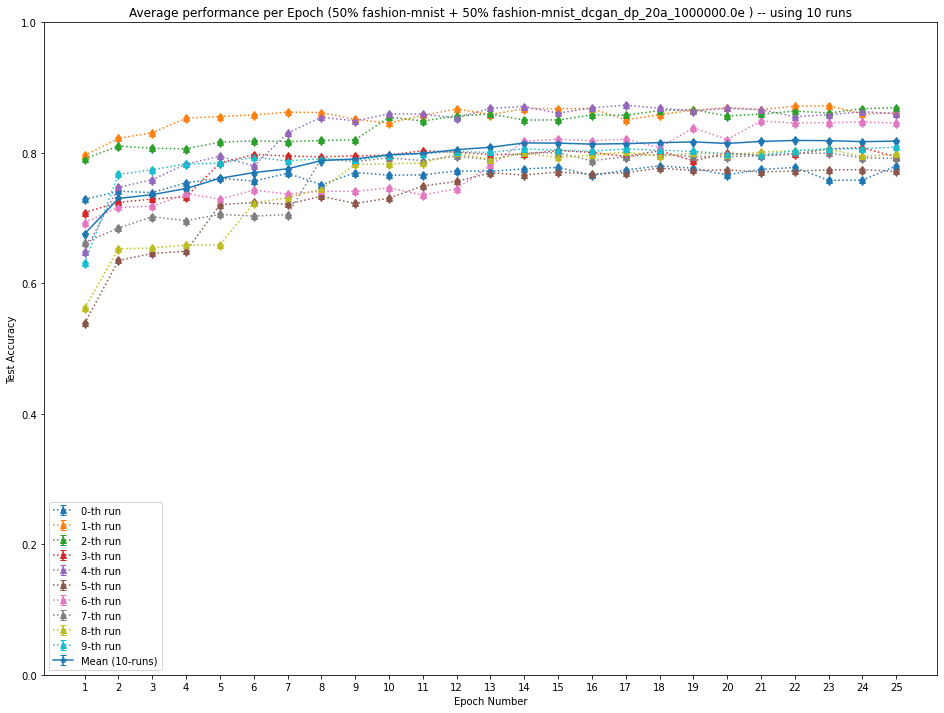

2021-01-31 22:01:55 53447080b262 04_mnist[351968] INFO >>> DONE Training, and Evaluating 
	 using fashion-mnist_dcgan_dp_20a_1000000.0e
 are complete
2021-01-31 22:01:55 53447080b262 04_mnist[351968] INFO ====
[RUN] starting run: 0
 ====
2021-01-31 22:01:55 53447080b262 csl.datasets[351968] INFO Processing 'fashion-mnist' torch.vision built-in structure
2021-01-31 22:01:55 53447080b262 csl.datasets[351968] INFO Loaded complete original 'fashion-mnist' dataset with 60000 training data and 10000 test data.
2021-01-31 22:01:55 53447080b262 csl.datasets[351968] INFO  > Splitted original 'fashion-mnist' dataset with 6000 training data and 10000 test data.
2021-01-31 22:01:55 53447080b262 csl.datasets[351968] INFO Processing 'fashion-mnist_dcgan_dp_20a_1000000.0e' ImageFolder structure
2021-01-31 22:01:55 53447080b262 csl.datasets[351968] INFO  Loaded complete synthetic 'fashion-mnist_dcgan_dp_20a_1000000.0e'  dataset with 60000 training data and 10000 test data.
2021-01-31 22:01:55 53447080

Train 0-run batch 18: 100%|██████████| 3750/3750 [00:15<00:00, 238.25it/s]
2021-01-31 22:07:50 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.66944
2021-01-31 22:07:53 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  0.70640
2021-01-31 22:07:53 53447080b262 04_mnist[351968] INFO   >> [NEXT] 
Start of epoch 19 using (10.0)% original and (90.0)% synthetic.
Train 0-run batch 19: 100%|██████████| 3750/3750 [00:15<00:00, 237.70it/s]
2021-01-31 22:08:09 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.66786
2021-01-31 22:08:12 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  0.73070
2021-01-31 22:08:12 53447080b262 04_mnist[351968] INFO   >> [NEXT] 
Start of epoch 20 using (10.0)% original and (90.0)% synthetic.
Train 0-run batch 20: 100%|██████████| 3750/3750 [00:15<00:00, 245.03it/s]
2021-01-31 22:08:28 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.66644
2021-01-31 22:08:31 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  

Train 1-run batch 11: 100%|██████████| 3750/3750 [00:16<00:00, 231.50it/s]
2021-01-31 22:13:31 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.61568
2021-01-31 22:13:34 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  0.81870
2021-01-31 22:13:34 53447080b262 04_mnist[351968] INFO   >> [NEXT] 
Start of epoch 12 using (10.0)% original and (90.0)% synthetic.
Train 1-run batch 12: 100%|██████████| 3750/3750 [00:15<00:00, 234.72it/s]
2021-01-31 22:13:50 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.61210
2021-01-31 22:13:53 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  0.82300
2021-01-31 22:13:53 53447080b262 04_mnist[351968] INFO   >> [NEXT] 
Start of epoch 13 using (10.0)% original and (90.0)% synthetic.
Train 1-run batch 13: 100%|██████████| 3750/3750 [00:15<00:00, 241.39it/s]
2021-01-31 22:14:09 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.60868
2021-01-31 22:14:11 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  

Train 2-run batch 4: 100%|██████████| 3750/3750 [00:15<00:00, 238.17it/s]
2021-01-31 22:19:10 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.59258
2021-01-31 22:19:13 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  0.79770
2021-01-31 22:19:13 53447080b262 04_mnist[351968] INFO   >> [NEXT] 
Start of epoch 5 using (10.0)% original and (90.0)% synthetic.
Train 2-run batch 5: 100%|██████████| 3750/3750 [00:15<00:00, 238.08it/s]
2021-01-31 22:19:29 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.59059
2021-01-31 22:19:32 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  0.81310
2021-01-31 22:19:32 53447080b262 04_mnist[351968] INFO   >> [NEXT] 
Start of epoch 6 using (10.0)% original and (90.0)% synthetic.
Train 2-run batch 6: 100%|██████████| 3750/3750 [00:15<00:00, 241.18it/s]
2021-01-31 22:19:48 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.58866
2021-01-31 22:19:51 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  0.814

2021-01-31 22:25:29 53447080b262 csl.datasets[351968] INFO  > Splitted original 'fashion-mnist' dataset with 6000 training data and 10000 test data.
2021-01-31 22:25:29 53447080b262 csl.datasets[351968] INFO Processing 'fashion-mnist_dcgan_dp_20a_1000000.0e' ImageFolder structure
2021-01-31 22:25:31 53447080b262 csl.datasets[351968] INFO  Loaded complete synthetic 'fashion-mnist_dcgan_dp_20a_1000000.0e'  dataset with 60000 training data and 10000 test data.
2021-01-31 22:25:31 53447080b262 csl.datasets[351968] INFO  > Splitted synthetic 'fashion-mnist_dcgan_dp_20a_1000000.0e' dataset with 54000 training data and 10000 test data.
2021-01-31 22:25:31 53447080b262 csl.datasets[351968] INFO Constructed a hybrid 'fashion-mnist_dcgan_dp_20a_1000000.0e' dataset with 0.10-original and 0.90-hybrid portions to produce 60000 training and 10000 test datasets.
2021-01-31 22:25:31 53447080b262 04_mnist[351968] INFO   >> [NEXT] 
Start of epoch 0 using (10.0)% original and (90.0)% synthetic.
Train 3-r

Train 3-run batch 19: 100%|██████████| 3750/3750 [00:15<00:00, 239.35it/s]
2021-01-31 22:31:47 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.59210
2021-01-31 22:31:50 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  0.67530
2021-01-31 22:31:50 53447080b262 04_mnist[351968] INFO   >> [NEXT] 
Start of epoch 20 using (10.0)% original and (90.0)% synthetic.
Train 3-run batch 20: 100%|██████████| 3750/3750 [00:15<00:00, 234.60it/s]
2021-01-31 22:32:06 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.59274
2021-01-31 22:32:09 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  0.68590
2021-01-31 22:32:09 53447080b262 04_mnist[351968] INFO   >> [NEXT] 
Start of epoch 21 using (10.0)% original and (90.0)% synthetic.
Train 3-run batch 21: 100%|██████████| 3750/3750 [00:15<00:00, 238.86it/s]
2021-01-31 22:32:25 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.59336
2021-01-31 22:32:28 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  

Train 4-run batch 12: 100%|██████████| 3750/3750 [00:15<00:00, 236.48it/s]
2021-01-31 22:37:28 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.58625
2021-01-31 22:37:30 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  0.82180
2021-01-31 22:37:30 53447080b262 04_mnist[351968] INFO   >> [NEXT] 
Start of epoch 13 using (10.0)% original and (90.0)% synthetic.
Train 4-run batch 13: 100%|██████████| 3750/3750 [00:15<00:00, 239.67it/s]
2021-01-31 22:37:46 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.58533
2021-01-31 22:37:49 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  0.80710
2021-01-31 22:37:49 53447080b262 04_mnist[351968] INFO   >> [NEXT] 
Start of epoch 14 using (10.0)% original and (90.0)% synthetic.
Train 4-run batch 14: 100%|██████████| 3750/3750 [00:15<00:00, 237.67it/s]
2021-01-31 22:38:05 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.58444
2021-01-31 22:38:08 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  

Train 5-run batch 5: 100%|██████████| 3750/3750 [00:15<00:00, 235.51it/s]
2021-01-31 22:43:08 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.57918
2021-01-31 22:43:11 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  0.79060
2021-01-31 22:43:11 53447080b262 04_mnist[351968] INFO   >> [NEXT] 
Start of epoch 6 using (10.0)% original and (90.0)% synthetic.
Train 5-run batch 6: 100%|██████████| 3750/3750 [00:15<00:00, 240.24it/s]
2021-01-31 22:43:26 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.57912
2021-01-31 22:43:30 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  0.80840
2021-01-31 22:43:30 53447080b262 04_mnist[351968] INFO   >> [NEXT] 
Start of epoch 7 using (10.0)% original and (90.0)% synthetic.
Train 5-run batch 7: 100%|██████████| 3750/3750 [00:15<00:00, 241.76it/s]
2021-01-31 22:43:45 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.57905
2021-01-31 22:43:48 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  0.806

2021-01-31 22:49:10 53447080b262 csl.datasets[351968] INFO  Loaded complete synthetic 'fashion-mnist_dcgan_dp_20a_1000000.0e'  dataset with 60000 training data and 10000 test data.
2021-01-31 22:49:10 53447080b262 csl.datasets[351968] INFO  > Splitted synthetic 'fashion-mnist_dcgan_dp_20a_1000000.0e' dataset with 54000 training data and 10000 test data.
2021-01-31 22:49:10 53447080b262 csl.datasets[351968] INFO Constructed a hybrid 'fashion-mnist_dcgan_dp_20a_1000000.0e' dataset with 0.10-original and 0.90-hybrid portions to produce 60000 training and 10000 test datasets.
2021-01-31 22:49:10 53447080b262 04_mnist[351968] INFO   >> [NEXT] 
Start of epoch 0 using (10.0)% original and (90.0)% synthetic.
Train 6-run batch 0: 100%|██████████| 3750/3750 [00:15<00:00, 236.63it/s]
2021-01-31 22:49:26 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.57804
2021-01-31 22:49:29 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  0.61870
2021-01-31 22:49:29 53447080b262 04_mnist[3

Train 6-run batch 20: 100%|██████████| 3750/3750 [00:15<00:00, 236.55it/s]
2021-01-31 22:55:43 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.59514
2021-01-31 22:55:46 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  0.64770
2021-01-31 22:55:46 53447080b262 04_mnist[351968] INFO   >> [NEXT] 
Start of epoch 21 using (10.0)% original and (90.0)% synthetic.
Train 6-run batch 21: 100%|██████████| 3750/3750 [00:16<00:00, 232.64it/s]
2021-01-31 22:56:02 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.59589
2021-01-31 22:56:05 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  0.63620
2021-01-31 22:56:06 53447080b262 04_mnist[351968] INFO   >> [NEXT] 
Start of epoch 22 using (10.0)% original and (90.0)% synthetic.
Train 6-run batch 22: 100%|██████████| 3750/3750 [00:15<00:00, 235.25it/s]
2021-01-31 22:56:22 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.59662
2021-01-31 22:56:24 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  

Train 7-run batch 13: 100%|██████████| 3750/3750 [00:15<00:00, 237.05it/s]
2021-01-31 23:01:24 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.60164
2021-01-31 23:01:27 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  0.78480
2021-01-31 23:01:27 53447080b262 04_mnist[351968] INFO   >> [NEXT] 
Start of epoch 14 using (10.0)% original and (90.0)% synthetic.
Train 7-run batch 14: 100%|██████████| 3750/3750 [00:15<00:00, 237.97it/s]
2021-01-31 23:01:43 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.60147
2021-01-31 23:01:46 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  0.77300
2021-01-31 23:01:46 53447080b262 04_mnist[351968] INFO   >> [NEXT] 
Start of epoch 15 using (10.0)% original and (90.0)% synthetic.
Train 7-run batch 15: 100%|██████████| 3750/3750 [00:15<00:00, 238.13it/s]
2021-01-31 23:02:02 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.60129
2021-01-31 23:02:05 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  

Train 8-run batch 6: 100%|██████████| 3750/3750 [00:15<00:00, 238.36it/s]
2021-01-31 23:07:04 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.60007
2021-01-31 23:07:07 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  0.79230
2021-01-31 23:07:07 53447080b262 04_mnist[351968] INFO   >> [NEXT] 
Start of epoch 7 using (10.0)% original and (90.0)% synthetic.
Train 8-run batch 7: 100%|██████████| 3750/3750 [00:15<00:00, 234.82it/s]
2021-01-31 23:07:23 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.59989
2021-01-31 23:07:26 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  0.78790
2021-01-31 23:07:26 53447080b262 04_mnist[351968] INFO   >> [NEXT] 
Start of epoch 8 using (10.0)% original and (90.0)% synthetic.
Train 8-run batch 8: 100%|██████████| 3750/3750 [00:15<00:00, 240.20it/s]
2021-01-31 23:07:41 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.59971
2021-01-31 23:07:44 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  0.796

2021-01-31 23:12:48 53447080b262 csl.datasets[351968] INFO Constructed a hybrid 'fashion-mnist_dcgan_dp_20a_1000000.0e' dataset with 0.10-original and 0.90-hybrid portions to produce 60000 training and 10000 test datasets.
2021-01-31 23:12:49 53447080b262 04_mnist[351968] INFO   >> [NEXT] 
Start of epoch 0 using (10.0)% original and (90.0)% synthetic.
Train 9-run batch 0: 100%|██████████| 3750/3750 [00:15<00:00, 240.22it/s]
2021-01-31 23:13:04 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.59805
2021-01-31 23:13:07 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  0.57070
2021-01-31 23:13:07 53447080b262 04_mnist[351968] INFO   >> [NEXT] 
Start of epoch 1 using (10.0)% original and (90.0)% synthetic.
Train 9-run batch 1: 100%|██████████| 3750/3750 [00:15<00:00, 237.52it/s]
2021-01-31 23:13:23 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.59865
2021-01-31 23:13:27 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  0.65950
2021-01-31 23:13:27 5

Train 9-run batch 21: 100%|██████████| 3750/3750 [00:15<00:00, 241.59it/s]
2021-01-31 23:19:42 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.59580
2021-01-31 23:19:44 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  0.76720
2021-01-31 23:19:44 53447080b262 04_mnist[351968] INFO   >> [NEXT] 
Start of epoch 22 using (10.0)% original and (90.0)% synthetic.
Train 9-run batch 22: 100%|██████████| 3750/3750 [00:16<00:00, 231.21it/s]
2021-01-31 23:20:01 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.59565
2021-01-31 23:20:04 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  0.76140
2021-01-31 23:20:04 53447080b262 04_mnist[351968] INFO   >> [NEXT] 
Start of epoch 23 using (10.0)% original and (90.0)% synthetic.
Train 9-run batch 23: 100%|██████████| 3750/3750 [00:15<00:00, 236.89it/s]
2021-01-31 23:20:20 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.59550
2021-01-31 23:20:23 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  

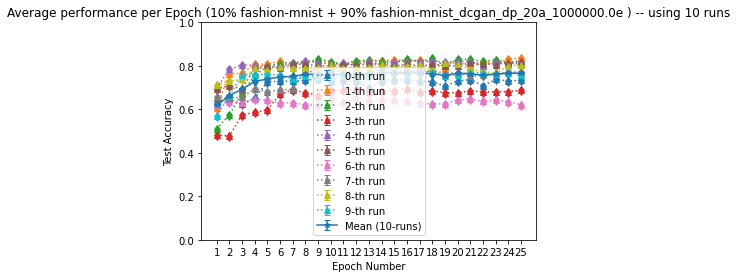

2021-01-31 23:20:43 53447080b262 04_mnist[351968] INFO >>> DONE Training, and Evaluating 
	 using fashion-mnist_dcgan_dp_20a_1000000.0e
 are complete
2021-01-31 23:20:43 53447080b262 04_mnist[351968] INFO ====
[RUN] starting run: 0
 ====
2021-01-31 23:20:43 53447080b262 csl.datasets[351968] INFO Processing 'fashion-mnist' torch.vision built-in structure
2021-01-31 23:20:43 53447080b262 csl.datasets[351968] INFO Loaded complete original 'fashion-mnist' dataset with 60000 training data and 10000 test data.
2021-01-31 23:20:43 53447080b262 csl.datasets[351968] INFO  > Splitted original 'fashion-mnist' dataset with 600 training data and 10000 test data.
2021-01-31 23:20:43 53447080b262 csl.datasets[351968] INFO Processing 'fashion-mnist_dcgan_dp_20a_1000000.0e' ImageFolder structure
2021-01-31 23:20:43 53447080b262 csl.datasets[351968] INFO  Loaded complete synthetic 'fashion-mnist_dcgan_dp_20a_1000000.0e'  dataset with 60000 training data and 10000 test data.
2021-01-31 23:20:43 53447080b

Train 0-run batch 18: 100%|██████████| 3750/3750 [00:15<00:00, 236.85it/s]
2021-01-31 23:26:37 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.57473
2021-01-31 23:26:40 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  0.69450
2021-01-31 23:26:40 53447080b262 04_mnist[351968] INFO   >> [NEXT] 
Start of epoch 19 using (1.0)% original and (99.0)% synthetic.
Train 0-run batch 19: 100%|██████████| 3750/3750 [00:15<00:00, 237.08it/s]
2021-01-31 23:26:56 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.57337
2021-01-31 23:26:59 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  0.68260
2021-01-31 23:26:59 53447080b262 04_mnist[351968] INFO   >> [NEXT] 
Start of epoch 20 using (1.0)% original and (99.0)% synthetic.
Train 0-run batch 20: 100%|██████████| 3750/3750 [00:15<00:00, 247.40it/s]
2021-01-31 23:27:14 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.57216
2021-01-31 23:27:17 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  0.

Train 1-run batch 11: 100%|██████████| 3750/3750 [00:15<00:00, 235.80it/s]
2021-01-31 23:32:16 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.54174
2021-01-31 23:32:18 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  0.76160
2021-01-31 23:32:18 53447080b262 04_mnist[351968] INFO   >> [NEXT] 
Start of epoch 12 using (1.0)% original and (99.0)% synthetic.
Train 1-run batch 12: 100%|██████████| 3750/3750 [00:15<00:00, 235.70it/s]
2021-01-31 23:32:34 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.53973
2021-01-31 23:32:37 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  0.76040
2021-01-31 23:32:37 53447080b262 04_mnist[351968] INFO   >> [NEXT] 
Start of epoch 13 using (1.0)% original and (99.0)% synthetic.
Train 1-run batch 13: 100%|██████████| 3750/3750 [00:16<00:00, 234.18it/s]
2021-01-31 23:32:53 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.53784
2021-01-31 23:32:56 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  0.

Train 2-run batch 4: 100%|██████████| 3750/3750 [00:15<00:00, 238.38it/s]
2021-01-31 23:37:55 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.52909
2021-01-31 23:37:58 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  0.75840
2021-01-31 23:37:58 53447080b262 04_mnist[351968] INFO   >> [NEXT] 
Start of epoch 5 using (1.0)% original and (99.0)% synthetic.
Train 2-run batch 5: 100%|██████████| 3750/3750 [00:15<00:00, 244.05it/s]
2021-01-31 23:38:13 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.52797
2021-01-31 23:38:16 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  0.74030
2021-01-31 23:38:16 53447080b262 04_mnist[351968] INFO   >> [NEXT] 
Start of epoch 6 using (1.0)% original and (99.0)% synthetic.
Train 2-run batch 6: 100%|██████████| 3750/3750 [00:15<00:00, 241.61it/s]
2021-01-31 23:38:32 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.52687
2021-01-31 23:38:35 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  0.76060

2021-01-31 23:44:09 53447080b262 csl.datasets[351968] INFO  > Splitted original 'fashion-mnist' dataset with 600 training data and 10000 test data.
2021-01-31 23:44:09 53447080b262 csl.datasets[351968] INFO Processing 'fashion-mnist_dcgan_dp_20a_1000000.0e' ImageFolder structure
2021-01-31 23:44:10 53447080b262 csl.datasets[351968] INFO  Loaded complete synthetic 'fashion-mnist_dcgan_dp_20a_1000000.0e'  dataset with 60000 training data and 10000 test data.
2021-01-31 23:44:10 53447080b262 csl.datasets[351968] INFO  > Splitted synthetic 'fashion-mnist_dcgan_dp_20a_1000000.0e' dataset with 59400 training data and 10000 test data.
2021-01-31 23:44:10 53447080b262 csl.datasets[351968] INFO Constructed a hybrid 'fashion-mnist_dcgan_dp_20a_1000000.0e' dataset with 0.01-original and 0.99-hybrid portions to produce 60000 training and 10000 test datasets.
2021-01-31 23:44:10 53447080b262 04_mnist[351968] INFO   >> [NEXT] 
Start of epoch 0 using (1.0)% original and (99.0)% synthetic.
Train 3-run

Train 3-run batch 19: 100%|██████████| 3750/3750 [00:16<00:00, 233.70it/s]
2021-01-31 23:50:23 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.51547
2021-01-31 23:50:26 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  0.75450
2021-01-31 23:50:26 53447080b262 04_mnist[351968] INFO   >> [NEXT] 
Start of epoch 20 using (1.0)% original and (99.0)% synthetic.
Train 3-run batch 20: 100%|██████████| 3750/3750 [00:15<00:00, 247.45it/s]
2021-01-31 23:50:41 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.51494
2021-01-31 23:50:44 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  0.72960
2021-01-31 23:50:44 53447080b262 04_mnist[351968] INFO   >> [NEXT] 
Start of epoch 21 using (1.0)% original and (99.0)% synthetic.
Train 3-run batch 21: 100%|██████████| 3750/3750 [00:15<00:00, 236.45it/s]
2021-01-31 23:51:00 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.51442
2021-01-31 23:51:03 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  0.

Train 4-run batch 12: 100%|██████████| 3750/3750 [00:15<00:00, 234.45it/s]
2021-01-31 23:56:01 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.51336
2021-01-31 23:56:04 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  0.68750
2021-01-31 23:56:04 53447080b262 04_mnist[351968] INFO   >> [NEXT] 
Start of epoch 13 using (1.0)% original and (99.0)% synthetic.
Train 4-run batch 13: 100%|██████████| 3750/3750 [00:15<00:00, 237.59it/s]
2021-01-31 23:56:20 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.51293
2021-01-31 23:56:22 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  0.73000
2021-01-31 23:56:22 53447080b262 04_mnist[351968] INFO   >> [NEXT] 
Start of epoch 14 using (1.0)% original and (99.0)% synthetic.
Train 4-run batch 14: 100%|██████████| 3750/3750 [00:15<00:00, 239.32it/s]
2021-01-31 23:56:38 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.51252
2021-01-31 23:56:41 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  0.

Train 5-run batch 5: 100%|██████████| 3750/3750 [00:15<00:00, 240.89it/s]
2021-02-01 00:01:40 53447080b262 04_mnist[351968] INFO  >>> Average train loss:  1.51424
2021-02-01 00:01:43 53447080b262 04_mnist[351968] INFO  >>> Test Accuracy:  0.77420
2021-02-01 00:01:43 53447080b262 04_mnist[351968] INFO   >> [NEXT] 
Start of epoch 6 using (1.0)% original and (99.0)% synthetic.
Train 5-run batch 6:  20%|█▉        | 745/3750 [00:04<00:12, 244.18it/s]

In [ ]:
plt.figure(figsize=(16, 12))
all_results = {}
all_labels = {}

# step 3:
for config_n, (original_portion, synthetic_portion) in enumerate(portions):
    # avoid zero data combination
    # start = 0.1 if original_portion==0.0 else 0.0
    augmented_perf = {}
    ave_test_accs = []
    std_test_accs = []
    plot_labels = []

    plot_number = 1
    augmented_perf = {}

    # plotting criteria
    train_losses = []
    test_accs = np.zeros((N_RUNS, N_EPOCHS), dtype=np.float)
    train_hist = []
    hybrid_kwargs["original_portion"] = original_portion
    hybrid_kwargs["synthetic_portion"] = synthetic_portion

    # each hybrid combination will run N_RUNS to produce mean performance
    for run in range(N_RUNS):
        log.info(f"====\n[RUN] starting run: {run}\n ====")
        # step 4:
        hybrid_kwargs["seed"] = run**8
        train_loader, test_loader = dsets.get_hybrid_dataloaders(
            **hybrid_kwargs
        )

        # reset the model
        model = gelman_Classifier()
        # model.apply(init_kaiming)  # init_xavier,
        model.apply(init_xavier)
        model_optimizer = optim.Adam(model.parameters(), lr=LR)
        model.to(DEVICE)
        criterion = nn.CrossEntropyLoss()

        # train:
        model.train()
        for epoch in range(N_EPOCHS):
            log.info(
                f"  >> [NEXT] \nStart of epoch {epoch} using "
                f"({original_portion * 100})% original and "
                f"({synthetic_portion * 100})% synthetic."
            )
            for batch_id, (x_batch_train, labels) in zip(
                tqdm(
                    range(len(train_loader)),
                    desc=f"Train {run}-run batch {epoch}"
                ),
                train_loader
            ):
                # zero out the gradients from the previous iteration
                model_optimizer.zero_grad()

                inp = Variable(
                    x_batch_train.to(DEVICE),
                    requires_grad=True
                )
                outputs = model.forward(inp)
                loss = criterion(outputs, labels.to(DEVICE))
                loss.backward()
                train_losses.append(loss.item())

                # perform the backpropagation
                model_optimizer.step()

            # accuracy and loss
            train_hist.append(np.array(train_losses).mean())
            log.info(f" >>> Average train loss: {train_hist[-1]: .5f}")

            # evaluate:
            model.eval()
            with torch.no_grad():
                acc_val = classifier_accuracy(model.eval(), test_loader)
                test_accs[run, epoch] = acc_val
            log.info(f" >>> Test Accuracy: {acc_val: .5f}")

        log.info(
            "DONE TRAINING AND TESTING THE CURRENT HYBRID SETUP -- PLOT!"
        )
    # # ---
    # The metrics & for the specific hybrid ratio/combination
    # plot (mean and std)
    ave_test_accs = test_accs.mean(axis=0)
    std_test_accs = test_accs.std(axis=0)

    if N_RUNS > 1:
        for i in range(len(test_accs)):
            plt.errorbar(
                range(1, N_EPOCHS + 1),
                test_accs[i, :],
                test_accs[i, :],
                uplims=True,
                lolims=True,
                linestyle=':',
                marker='^',
                label=f"{i}-th run",
            )

        # Add Figure Title
        plt.title(
            f"Average performance per Epoch ({int(100*original_portion)}% "
            f"{DATASET_NAME} + {int(100*synthetic_portion)}% "
            f"{SYNTHETIC_DATASET_NAME} ) -- using {N_RUNS} runs"
        )
    else:
        plt.plot(
            range(1, N_EPOCHS + 1),
            ave_test_accs[0],
            label=f"{i}-th run",
        )
        # Add Figure Title
        plt.title(
            f"Performance per Epoch ({int(100*original_portion)}% "
            f"of {DATASET_NAME}) -- using a {N_RUNS} runs"
        )

    plt.errorbar(
        range(1, N_EPOCHS + 1),
        ave_test_accs,
        std_test_accs,
        uplims=True,
        lolims=True,
        linestyle='-',  # 'None',
        marker='*',
        label=f"Mean ({N_RUNS}-runs)",
    )
    result_label = (
        f"{int(100*original_portion)}%-{DATASET_NAME}"
        f" + {int(100*synthetic_portion)}%-{SYNTHETIC_DATASET_NAME}"
    )
    all_results[config_n] = (ave_test_accs, std_test_accs, result_label)

    # Add Figure Additional Information
    plt.xlabel("Epoch Number")
    plt.ylabel("Test Accuracy")
    plt.ylim((0, 1.))
    plt.xticks(np.arange(1, N_EPOCHS + 1, 1.0))
    plt.legend()
    plot_name = (
        f"plots/{SYNTHETIC_DATASET_NAME}/classification_with_"
        f"{int(original_portion*100)}_percent_{DATASET_NAME}_"
        f"{N_RUNS}runs_{N_EPOCHS}epochs.png"
        # f"and_various_synthetic_portions.png"
    )
    # step 5a:
    plt.savefig(plot_name)
    plt.show()

    log.info(
        f">>> DONE Training, and Evaluating \n\t"
        f" using {SYNTHETIC_DATASET_NAME}\n are complete"
    )

In [ ]:
# step 5b
# SUMMARY FIGURE: AVERAGE PERFORMANCE OF ALL CONFIGURATION
plt.figure(figsize=(16, 12))
for i in range(len(all_results)):
    plt.errorbar(
        range(1, N_EPOCHS + 1),
        all_results[i][0],
        all_results[i][1],
        uplims=True,
        lolims=True,
        linestyle='--',
        marker='^',
        label=f"{all_results[i][2]} ({all_results[i][0].max():.2f} accuracy)",
    )
plt.title(
    f"Performance per Epoch using {DATASET_NAME} + "
    f"{SYNTHETIC_DATASET_NAME} ({N_RUNS}-run average)"
)
# Add Figure Additional Information
plt.xlabel("Epoch Number")
plt.ylabel("Test Accuracy")
plt.ylim((0, 1.))
plt.xticks(np.arange(1, N_EPOCHS + 1, 1.0))
plt.legend()
plot_name = (
    f"plots/{SYNTHETIC_DATASET_NAME}/overall_classification_using_"
    f"{DATASET_NAME}_{N_RUNS}runs_and_{N_EPOCHS}epochs.png"
)
plt.savefig(plot_name)
plt.show()


print("COMPLETE FULL CODE EXECUTION")